### Akjan


In [1]:
%pip install ftfy

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import ftfy
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import shuffle 
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.preprocessing.text import Tokenizer

np.random.seed(500)
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mansur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mansur/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mansur/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mansur/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /Users/mansur/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [7]:
path = r'/Users/mansur/Desktop/kbtu/ai/final/depressive_tweets_processed.csv'
depressive_dataset = pd.read_csv(path, sep='|', header = None, usecols=range(0,9), nrows=3200)

In [8]:
depressive_dataset.head()

,0,1,2,3,4,5,6,7,8
0,989292962323615744,2018-04-25,23:59:57,Eastern Standard Time,whosalli,The lack of this understanding is a small but ...,1,0,3
1,989292959844663296,2018-04-25,23:59:56,Eastern Standard Time,estermnunes,i just told my parents about my depression and...,1,0,2
2,989292951716155392,2018-04-25,23:59:54,Eastern Standard Time,TheAlphaAries,depression is something i don't speak about ev...,0,0,0
3,989292873664393218,2018-04-25,23:59:35,Eastern Standard Time,_ojhodgson,Made myself a tortilla filled with pb&j. My de...,1,0,0
4,989292856119472128,2018-04-25,23:59:31,Eastern Standard Time,DMiller96371630,@WorldofOutlaws I am gonna need depression med...,0,0,0


In [9]:
len(depressive_dataset)

2345

In [10]:
for i in range(3):
  print(depressive_dataset[5][i])

The lack of this understanding is a small but significant part of what causes anxiety & depression to both feel so incredibly lonely. It's soooo easy to compare. It's so easy to invalidate ourselves because of that.
i just told my parents about my depression and it's so hard to get gen x people to understand that this is not something that i can control all the time or just cure with a walk or by keeping my mind busy
depression is something i don't speak about even going through it because it's also such a double edged sword. i love every race. even if white people had done so much i can't hate them all. my grandma is legit white! how tf can i hate, i do dislike people though.


In [12]:
path2 = r'/Users/mansur/Desktop/kbtu/ai/final/Sentiment Analysis Dataset 2.csv'
non_depressive_data = pd.read_csv(path2, encoding = "ISO-8859-1", usecols = range(0,4), nrows = 10000)

In [13]:
non_depressive_data[1000:].head()

,ï»¿ItemID,Sentiment,SentimentSource,SentimentText
1000,1001,1,Sentiment140,"- Fwd: Good Morn,happy birthday ! regardless ..."
1001,1002,0,Sentiment140,gah. so much less ok than i was trying to tel...
1002,1003,0,Sentiment140,GCSE's clearly suck.
1003,1004,0,Sentiment140,- Geez Chelsea already scored against Everton ...
1004,1005,0,Sentiment140,gerald lost a friend............idk what to s...


In [14]:
len(non_depressive_data)

10000

#Data Preprocessing

In [15]:
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))
def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [19]:
import nltk

nltk.download("punkt")
nltk.download("punkt_tab")              # иногда требуется в новых сборках
nltk.download("averaged_perceptron_tagger")
nltk.download("averaged_perceptron_tagger_eng")  # если NLTK просит *_eng
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")


[nltk_data] Downloading package punkt to /Users/mansur/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/mansur/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mansur/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/mansur/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mansur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mansur/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/mansur/nltk_data...
[nltk_data]   Package omw-1.4

True

In [20]:
def preprocess_data(dataset):
  cleaned_data = []
  # Remove blank rows if any.
  dataset.dropna(inplace=True)
  #Tokenization
  dataset = [word_tokenize(str(entry)) for entry in dataset]

  # WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
  tag_map = defaultdict(lambda : wn.NOUN)
  tag_map['J'] = wn.ADJ
  tag_map['V'] = wn.VERB
  tag_map['R'] = wn.ADV

  for tweet in dataset:
    cleaned_tweet = []
    tweet = str(tweet)
    # if url links then dont append to avoid news articles also check tweet length, save those > 10 (length of word "depression")
    if re.match("(\w+:\/\/\S+)", tweet) == None and len(tweet) > 10:
      # Change all the text to lower case.
      tweet = tweet.lower()
      #remove hashtag, @mention, emoji and image URLs
      tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)|(pic\.twitter\.com\/.*)", " ", tweet).split())
      #fix weirdly encoded texts
      tweet = ftfy.fix_text(tweet)
      #expand contraction
      tweet = expandContractions(tweet)
      #remove punctuation
      tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())
      #stop words
      stop_words = set(stopwords.words('english'))
      word_tokens = nltk.word_tokenize(tweet) 
      filtered_sentence = [w for w in word_tokens if not w in stop_words]
      tweet = ' '.join(filtered_sentence)
      # Initializing WordNetLemmatizer()
      word_Lemmatized = WordNetLemmatizer()
      #pos_tag function below will provide the 'tag' i.e if the word is Noun(N), Verb(V) etc.
      for word, tag in pos_tag(word_tokenize(tweet)):
        w = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
        cleaned_tweet.append(w)
    cleaned_data.append(str(cleaned_tweet))
  return pd.DataFrame(cleaned_data)

In [21]:
dep_tweets = preprocess_data(depressive_dataset[5])
dep_tweets.head()

,0
0,"['lack', 'understand', 'small', 'significant',..."
1,"['told', 'parent', 'depression', 'hard', 'get'..."
2,"['depression', 'something', 'n', 'speak', 'eve..."
3,"['make', 'tortilla', 'fill', 'pb', 'j', 'depre..."
4,"['worldofoutlaws', 'gon', 'na', 'need', 'depre..."


In [22]:
non_dep_tweets = preprocess_data(non_depressive_data['SentimentText'])
non_dep_tweets.head()

,0
0,"['sad', 'apl', 'friend']"
1,"['miss', 'new', 'moon', 'trailer']"
2,"['omg', 'already', '7', '30']"
3,"['omgaga', 'im', 'sooo', 'im', 'gunna', 'cry',..."
4,"['think', 'mi', 'bf', 'cheat']"


#Split into Train and Test Data sets

In [24]:
# Assigning labels to the depressive tweets and random tweets data
labels_d = pd.DataFrame(np.array([1] * len(dep_tweets)))
labels_r = pd.DataFrame(np.array([0] * len(non_dep_tweets)))

#Merge depression and random tweet datasets and shuffle
frames = pd.concat([dep_tweets, non_dep_tweets])
labels = pd.concat([labels_d, labels_r])
dataset = pd.concat([frames, labels], axis="columns")
dataset.set_axis(['text', 'label'], axis=1, inplace=True)
dataset = shuffle(dataset, random_state=500).reset_index(drop=True)
dataset.head()

TypeError: set_axis() got an unexpected keyword argument 'inplace'

In [25]:
labels_d = pd.DataFrame([1] * len(dep_tweets))
labels_r = pd.DataFrame([0] * len(non_dep_tweets))

frames = pd.concat([dep_tweets, non_dep_tweets], ignore_index=True)
labels = pd.concat([labels_d, labels_r], ignore_index=True)

dataset = pd.concat([frames, labels], axis=1)
dataset = dataset.set_axis(['text', 'label'], axis=1)

dataset = shuffle(dataset, random_state=500).reset_index(drop=True)
dataset.head()


,text,label
0,"['depression', 'ca', 'n', 'cure', 'though', 'n...",1
1,"['oh', 'cohan', 'twitter']",0
2,"['always', 'show', 'right', 'time', 'istillbel...",0
3,"['miss', 'u', 'miss', 'old', 'time', 'guyz']",0
4,"['aion', 'beta', 'start', '3am', 'wa', 'player...",0


In [26]:
#Train and Test split
train_X, test_X, train_y, test_y = model_selection.train_test_split(dataset['text'], dataset['label'], test_size=0.3)

##Visualization to better understand the text data

In [27]:
#Word vectorization to assign word frequency scores
#We have used TF-IDF: “Term Frequency — Inverse Document”
tfidf_vect = TfidfVectorizer(max_features=5000) #There will be maximum of 5000 unique words
tfidf_vect.fit(dataset['text'])
train_X_vect = tfidf_vect.transform(train_X)
test_X_vect = tfidf_vect.transform(test_X)

print(tfidf_vect.vocabulary_)

{'depression': 1165, 'ca': 743, 'cure': 1052, 'though': 4445, 'next': 3038, 'http': 2205, 'twitter': 4601, 'com': 920, 'ayanatheoracle': 456, 'status': 4204, '988861135142248449': 174, 'oh': 3131, 'always': 297, 'show': 3954, 'right': 3727, 'time': 4474, 'read': 3595, 'bit': 579, 'ly': 2697, 'miss': 2881, 'old': 3141, 'guyz': 2009, 'aion': 261, 'beta': 551, 'start': 4198, '3am': 112, 'wa': 4727, 'player': 3345, 'know': 2521, 'force': 1720, 'stay': 4206, 'awake': 443, 'long': 2659, 'must': 2979, 'goodness': 1933, 'move': 2949, 'life': 2607, 'mean': 2777, 'wait': 4731, 'year': 4952, 'believe': 539, 'say': 3831, 'mom': 2909, 'like': 2613, 'version': 4684, 'technology': 4380, 'good': 1929, 'thing': 4435, 'clue': 898, 'traffic': 4527, 'report': 3669, '16': 33, 'amp': 311, 'get': 1871, '20': 52, 'avoid': 441, 'plague': 3335, '11': 19, 'symptom': 4337, 'men': 2808, 'differ': 1210, 'woman': 4856, 'https': 2206, 'ift': 2250, 'tt': 4574, '2humcsy': 87, 'quot': 3550, 'look': 2661, 'someone': 4111

In [28]:
depressive_vect = TfidfVectorizer(max_features=25)
depressive_vect.fit_transform(dep_tweets[0])
nondepressive_vect = TfidfVectorizer(max_features=25)
nondepressive_vect.fit_transform(non_dep_tweets[0])
nondepressive_vect.get_feature_names_out()

array(['amp', 'back', 'com', 'day', 'followfriday', 'get', 'go', 'good',
       'http', 'im', 'know', 'like', 'love', 'lt', 'make', 'miss', 'na',
       'one', 'quot', 'see', 'think', 'time', 'today', 'want', 'work'],
      dtype=object)

In [29]:
# Generate a word cloud image
text = np.array_str(depressive_vect.get_feature_names_out())
wordcloud = WordCloud().generate(text)
text2 = np.array_str(nondepressive_vect.get_feature_names_out())
wordcloud2 = WordCloud().generate(text2)

# Display the generated image:
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(1,2,1)
ax2 = f.add_subplot(1,2,2)
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_title("Sample words from Depressive Tweets Data")
ax.axis("off")
ax2.imshow(wordcloud2, interpolation='bilinear')
ax2.axis("off")
ax2.set_title("Sample words from Non Depressive Tweets Data")
f.show()

TypeError: asarray() got an unexpected keyword argument 'copy'

Error in callback <function _draw_all_if_interactive at 0x12b10e9d0> (for post_execute), with arguments args (),kwargs {}:


ValueError: object __array__ method not producing an array

ValueError: object __array__ method not producing an array

<Figure size 2000x1000 with 2 Axes>

In [30]:
text_dep = " ".join(depressive_vect.get_feature_names_out())
text_non = " ".join(nondepressive_vect.get_feature_names_out())


In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc1 = WordCloud(width=800, height=400, background_color="white").generate(text_dep)
wc2 = WordCloud(width=800, height=400, background_color="white").generate(text_non)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(wc1.to_image(), interpolation="bilinear")
ax[0].set_title("Sample words from Depressive Tweets Data")
ax[0].axis("off")

ax[1].imshow(wc2.to_image(), interpolation="bilinear")
ax[1].set_title("Sample words from Non Depressive Tweets Data")
ax[1].axis("off")

plt.show()


ValueError: object __array__ method not producing an array

<Figure size 2000x1000 with 2 Axes>

#SVM Classifier Model

In [ ]:
# SVM Classifier
SVM = svm.SVC(kernel='rbf', C=1.0, gamma=0.01)
SVM.fit(train_X_vect,train_y)
# predict
svm_classifier = SVM.predict(test_X_vect)
# Get the accuracy
print("SVM Model Accuracy:",accuracy_score(svm_classifier, test_y)*100)

SVM Model Accuracy: 84.97563616675691


In [ ]:
print(classification_report(test_y, svm_classifier))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      2976
           1       1.00      0.23      0.37       718

    accuracy                           0.85      3694
   macro avg       0.92      0.61      0.64      3694
weighted avg       0.87      0.85      0.81      3694



In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[ 163  555]
 [   0 2976]]


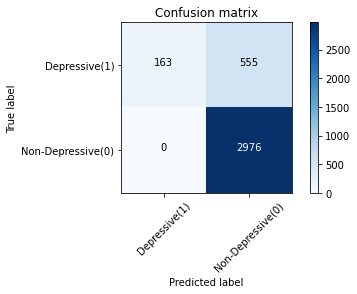

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(test_y, svm_classifier, labels=[1,0])
plt.figure()
plot_confusion_matrix(cm, classes=['Depressive(1)','Non-Depressive(0)'])

#Parameter Tuning



In [ ]:
model = svm.SVC(kernel='rbf')
C_range = [1,2,3,4]
gamma_range = [1e-1, 1e-2, 1e-3, 1e-4]
param_gs = dict(gamma=gamma_range, C=C_range)
gs = GridSearchCV(model, param_grid=param_gs, cv=2, pre_dispatch='1*n_jobs', n_jobs=1)
gs.fit(train_X_vect,train_y)

print(f'The best parameters are {gs.best_params_} with a best score of {gs.best_score_}')

The best parameters are {'C': 4, 'gamma': 0.1} with a best score of 0.99709941798825


Text(0.5, 0, 'C range')

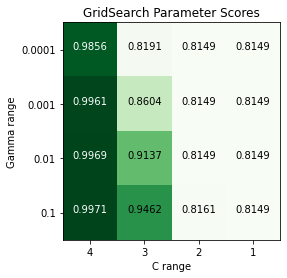

In [ ]:
#Visualization
scores = gs.cv_results_['mean_test_score']
scores = np.array(scores).reshape(len(C_range), len(gamma_range))

plt.imshow(scores, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("GridSearch Parameter Scores")
tick_marks = np.arange(len(C_range))
plt.xticks(tick_marks, reversed(C_range))
plt.yticks(tick_marks, reversed(gamma_range))
for i, j in itertools.product(range(scores.shape[0]), range(scores.shape[1])):
    plt.text(j, i, format(scores[i, j], '.4f'), horizontalalignment="center", color="black" if scores[i, j]<0.95 else "white")
plt.ylabel('Gamma range')
plt.xlabel('C range')

In [ ]:
# SVM Classifier with updated hyperparameters
SVM_updated = svm.SVC(kernel='rbf', C=4.0, gamma=0.1)
SVM_updated.fit(train_X_vect,train_y)
# predict
predicted = SVM_updated.predict(test_X_vect)
# Get the accuracy
print("Updated SVM Model Accuracy:", accuracy_score(predicted, test_y)*100,"\n")
print(classification_report(test_y, predicted))

Updated SVM Model Accuracy: 99.64807796426638 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2976
           1       1.00      0.98      0.99       718

    accuracy                           1.00      3694
   macro avg       1.00      0.99      0.99      3694
weighted avg       1.00      1.00      1.00      3694



[[ 706   12]
 [   1 2975]]


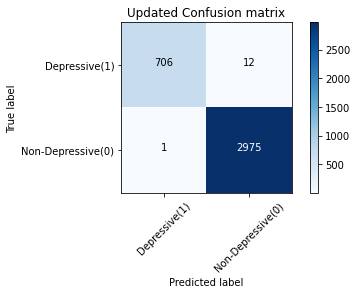

In [ ]:
# Compute confusion matrix
cm_updated = confusion_matrix(test_y, predicted, labels=[1,0])
plt.figure()
plot_confusion_matrix(cm_updated, classes=['Depressive(1)','Non-Depressive(0)'], title='Updated Confusion matrix')

### all

In [34]:
# Depression classification with SVM (end-to-end project)
# Works with:
#  - /mnt/data/depressive_tweets_processed.csv
#  - /mnt/data/Sentiment Analysis Dataset 2.csv

import re
import csv
import string
import random
from pathlib import Path

import numpy as np
import pandas as pd

import ftfy

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import joblib


# ---------------------------
# 1) Paths
# ---------------------------
DEPRESSIVE_PATH = r"/Users/mansur/Desktop/kbtu/ai/final/depressive_tweets_processed.csv"
SENTIMENT_PATH  = r"/Users/mansur/Desktop/kbtu/ai/final/Sentiment Analysis Dataset 2.csv"

OUT_DIR = Path(r"/Users/mansur/Desktop/kbtu/ai/final/depression_svm_out")
OUT_DIR.mkdir(parents=True, exist_ok=True)

MODEL_PATH = OUT_DIR / "svm_depression_model.joblib"
VECT_PATH  = OUT_DIR / "tfidf_vectorizer.joblib"


# ---------------------------
# 2) Load datasets (robust)
# ---------------------------
def load_depressive_dataset(path: str) -> pd.DataFrame:
    """
    This file is pipe-separated and may contain malformed rows.
    We'll parse with python engine, no quoting, and skip bad lines.
    """
    # There are 10 columns in your file (based on preview); we name only what we use.
    colnames = [
        "ID", "Date", "Time", "Timezone", "User",
        "Text", "Polarity", "Col8", "Col9", "Col10"
    ]
    df = pd.read_csv(
        path,
        sep="|",
        header=None,
        names=colnames,
        engine="python",
        quoting=csv.QUOTE_NONE,
        on_bad_lines="skip"
    )
    # Keep only text
    df = df[["Text"]].copy()
    return df

def load_sentiment_dataset(path: str) -> pd.DataFrame:
    """
    Typical Kaggle sentiment dataset:
      - Sentiment (0/1)
      - SentimentText (text)
    We'll use SentimentText as "non-depressive" pool.
    """
    df = pd.read_csv(path, engine="python", on_bad_lines="skip")
    # Normalize column names just in case
    expected_text_col = None
    for c in df.columns:
        if c.lower() in ["sentimenttext", "text", "sentence", "content"]:
            expected_text_col = c
            break
    if expected_text_col is None:
        raise ValueError(f"Не нашёл текстовую колонку в sentiment dataset. Колонки: {list(df.columns)}")

    df = df[[expected_text_col]].rename(columns={expected_text_col: "Text"}).copy()
    return df


depressive_df = load_depressive_dataset(DEPRESSIVE_PATH)
sentiment_df  = load_sentiment_dataset(SENTIMENT_PATH)

print("Depressive dataset shape:", depressive_df.shape)
print("Sentiment dataset shape:", sentiment_df.shape)


# ---------------------------
# 3) Text preprocessing (fixes float/NaN issue)
# ---------------------------
URL_RE = re.compile(r"(https?://\S+|www\.\S+)")
MENTION_RE = re.compile(r"@\w+")
HASHTAG_RE = re.compile(r"#\w+")
MULTISPACE_RE = re.compile(r"\s+")
NON_ALPHA_RE = re.compile(r"[^a-z\s]")

def preprocess_text(text) -> str:
    """
    Key fix vs your error:
      - handle NaN/float
      - ensure string before ftfy.fix_text()
    """
    # Handle NaN / None
    if text is None or (isinstance(text, float) and np.isnan(text)):
        return ""

    # Convert any non-string (e.g., floats) safely to string
    if not isinstance(text, str):
        text = str(text)

    # Fix unicode issues (ftfy expects a string with len())
    text = ftfy.fix_text(text)

    # Lowercase
    text = text.lower()

    # Remove urls, mentions, hashtags
    text = URL_RE.sub(" ", text)
    text = MENTION_RE.sub(" ", text)
    text = HASHTAG_RE.sub(" ", text)

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Keep only latin letters + spaces (SVM baseline; if you need multilingual — поменяем)
    text = NON_ALPHA_RE.sub(" ", text)

    # Normalize spaces
    text = MULTISPACE_RE.sub(" ", text).strip()

    return text


# Apply preprocessing
depressive_df["cleaned_text"] = depressive_df["Text"].apply(preprocess_text)
sentiment_df["cleaned_text"]  = sentiment_df["Text"].apply(preprocess_text)

# Drop empty
depressive_df = depressive_df[depressive_df["cleaned_text"].str.len() > 0].copy()
sentiment_df  = sentiment_df[sentiment_df["cleaned_text"].str.len() > 0].copy()

print("After cleaning:")
print("Depressive:", depressive_df.shape)
print("Sentiment:", sentiment_df.shape)


# ---------------------------
# 4) Build labeled dataset
# ---------------------------
# Label depressive as 1
depressive_df["label"] = 1

# For non-depressive, sample from sentiment dataset as label 0
# Balance to depressive size (or cap if sentiment smaller)
n_dep = len(depressive_df)
n_non = min(len(sentiment_df), n_dep)

sentiment_sample = sentiment_df.sample(n=n_non, random_state=42).copy()
sentiment_sample["label"] = 0

data = pd.concat(
    [
        depressive_df[["cleaned_text", "label"]],
        sentiment_sample[["cleaned_text", "label"]],
    ],
    ignore_index=True
)

# Shuffle
data = data.sample(frac=1.0, random_state=42).reset_index(drop=True)

print("Final dataset shape:", data.shape)
print("Label distribution:\n", data["label"].value_counts())


# ---------------------------
# 5) Train/test split
# ---------------------------
X = data["cleaned_text"].values
y = data["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


# ---------------------------
# 6) TF-IDF + SVM
# ---------------------------
vectorizer = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    min_df=2
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec  = vectorizer.transform(X_test)

model = LinearSVC(random_state=42)
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))


# ---------------------------
# 7) Save artifacts
# ---------------------------
joblib.dump(model, MODEL_PATH)
joblib.dump(vectorizer, VECT_PATH)

print("\nSaved:")
print("Model:", MODEL_PATH)
print("Vectorizer:", VECT_PATH)


# ---------------------------
# 8) Quick inference helper
# ---------------------------
def predict_depression(texts):
    """
    texts: str or list[str]
    returns: np.array of predicted labels (1=depressive, 0=non-depressive)
    """
    if isinstance(texts, str):
        texts = [texts]
    cleaned = [preprocess_text(t) for t in texts]
    vec = vectorizer.transform(cleaned)
    return model.predict(vec)

# Example:
# print(predict_depression(["i feel empty and hopeless", "what a wonderful day"]))


Depressive dataset shape: (4069, 1)
Sentiment dataset shape: (1578601, 1)
After cleaning:
Depressive: (4069, 2)
Sentiment: (1574799, 2)
Final dataset shape: (8138, 2)
Label distribution:
 label
1    4069
0    4069
Name: count, dtype: int64

Accuracy: 0.9686732186732187

Classification report:
               precision    recall  f1-score   support

           0     0.9494    0.9902    0.9693       814
           1     0.9897    0.9472    0.9680       814

    accuracy                         0.9687      1628
   macro avg     0.9695    0.9687    0.9687      1628
weighted avg     0.9695    0.9687    0.9687      1628


Confusion matrix:
 [[806   8]
 [ 43 771]]

Saved:
Model: /Users/mansur/Desktop/kbtu/ai/final/depression_svm_out/svm_depression_model.joblib
Vectorizer: /Users/mansur/Desktop/kbtu/ai/final/depression_svm_out/tfidf_vectorizer.joblib


In [35]:
# Example:
print(predict_depression(["i feel empty and hopeless", "what a wonderful day"]))


[1 0]
